In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import warnings

warnings.filterwarnings('ignore')

# Preprocessing and clustering

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.2 scipy==1.6.1 pandas==1.2.2 scikit-learn==0.23.2 statsmodels==0.12.2


In [3]:
results_file = '../data/small_screen/small_screen_results.h5ad'

### Read in the count matrix into an `AnnData`

In [4]:
adata = sc.read_10x_mtx(
    '../data/small_screen/',               # the directory with the `.mtx` file
     var_names='gene_symbols',   # use gene symbols for the variable names (variables-axis index)
     cache=True)   

... writing an h5ad cache file to speedup reading next time


In [5]:
adata

AnnData object with n_obs × n_vars = 24262 × 58347
    var: 'gene_ids'

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


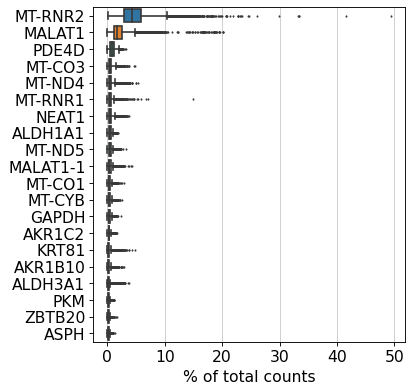

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering:

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 22431 genes that are detected in less than 3 cells


Some information about mitochondrial genes:

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

A violin plot of some of the computed quality measures:

1. the number of genes expressed in the count matrix
2. the total counts per cell
3. the percentage of counts in mitochondrial genes

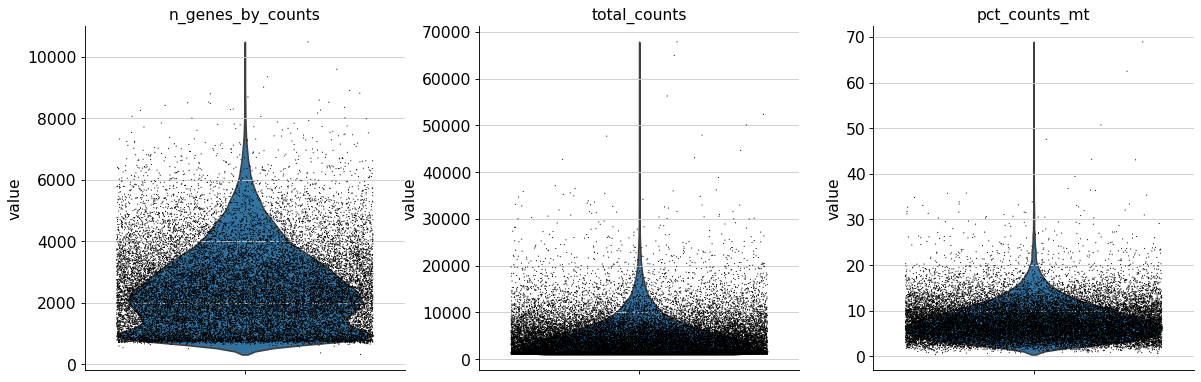

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

We need to remove cells that have too many mitochondrial genes expressed or too many total counts:

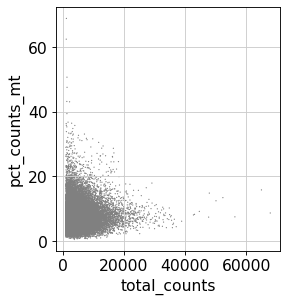

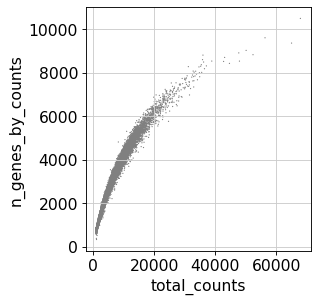

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Filtering:

In [11]:
adata = adata[adata.obs.n_genes_by_counts < 8000, :]
adata = adata[adata.obs.pct_counts_mt < 25, :]

Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.

In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


Logarithmize the data:

In [13]:
sc.pp.log1p(adata)

Identify highly-variable genes:

In [14]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


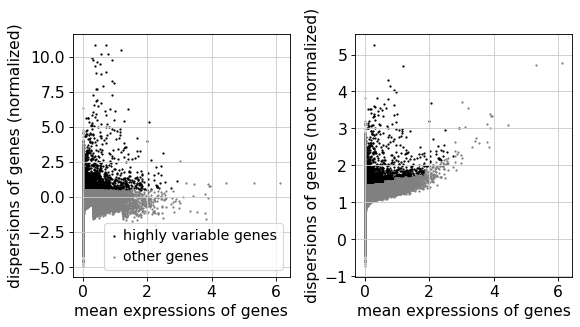

In [15]:
sc.pl.highly_variable_genes(adata)

Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object

In [16]:
adata.raw = adata

Filtering:

In [17]:
adata = adata[:, adata.var.highly_variable]

In [18]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:01:51)


In [19]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

In [20]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:18)


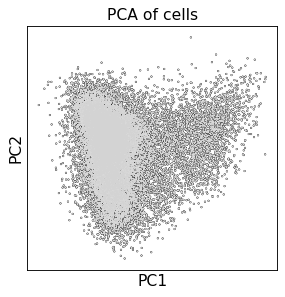

In [44]:
sc.pl.pca(adata, add_outline=True, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2,
           title='PCA of cells', palette='Set1')

Let us inspect the contribution of single PCs to the total variance in the data:

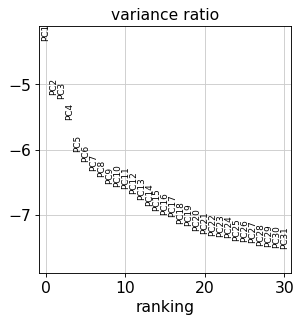

In [29]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result

In [30]:
adata.write(results_file)

In [31]:
adata

AnnData object with n_obs × n_vars = 24135 × 4194
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

Here I used default parameters from scanpy tutorial, mb I will change it futher:

In [32]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)


## Embedding the neighborhood graph

tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')

In [34]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


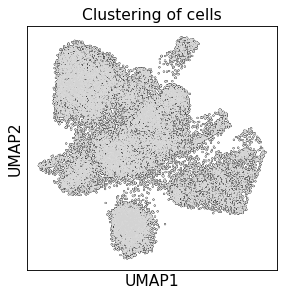

In [39]:
sc.pl.umap(adata, add_outline=True, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2,
           title='Clustering of cells', palette='Set1')

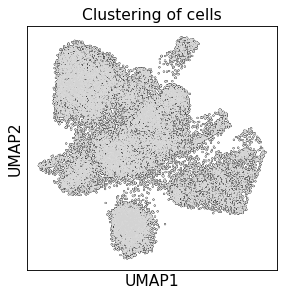

In [40]:
sc.pl.umap(adata, add_outline=True, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2,
           title='Clustering of cells', palette='Set1', 
           use_raw=False)

## Clustering the neighborhood graph

Leiden graph-clustering method:

In [45]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)


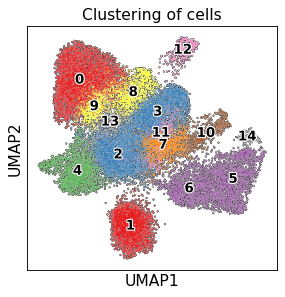

In [48]:
sc.pl.umap(adata, color='leiden', add_outline=True, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2,
           title='Clustering of cells', palette='Set1')

Save the result:

In [49]:
adata.write(results_file)

## Finding marker genes

Computation a ranking for the highly differential genes in each cluster

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:09)


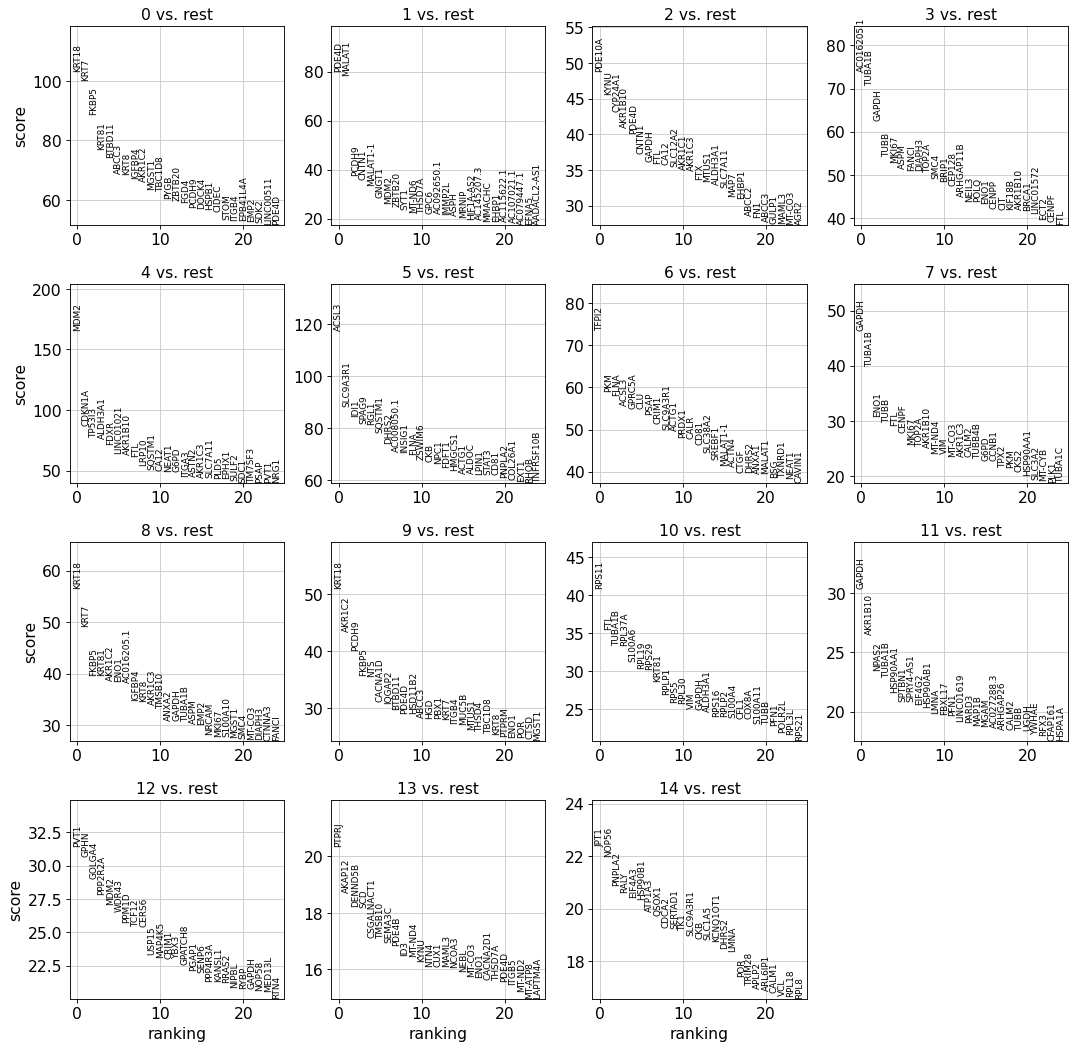

In [50]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:10)


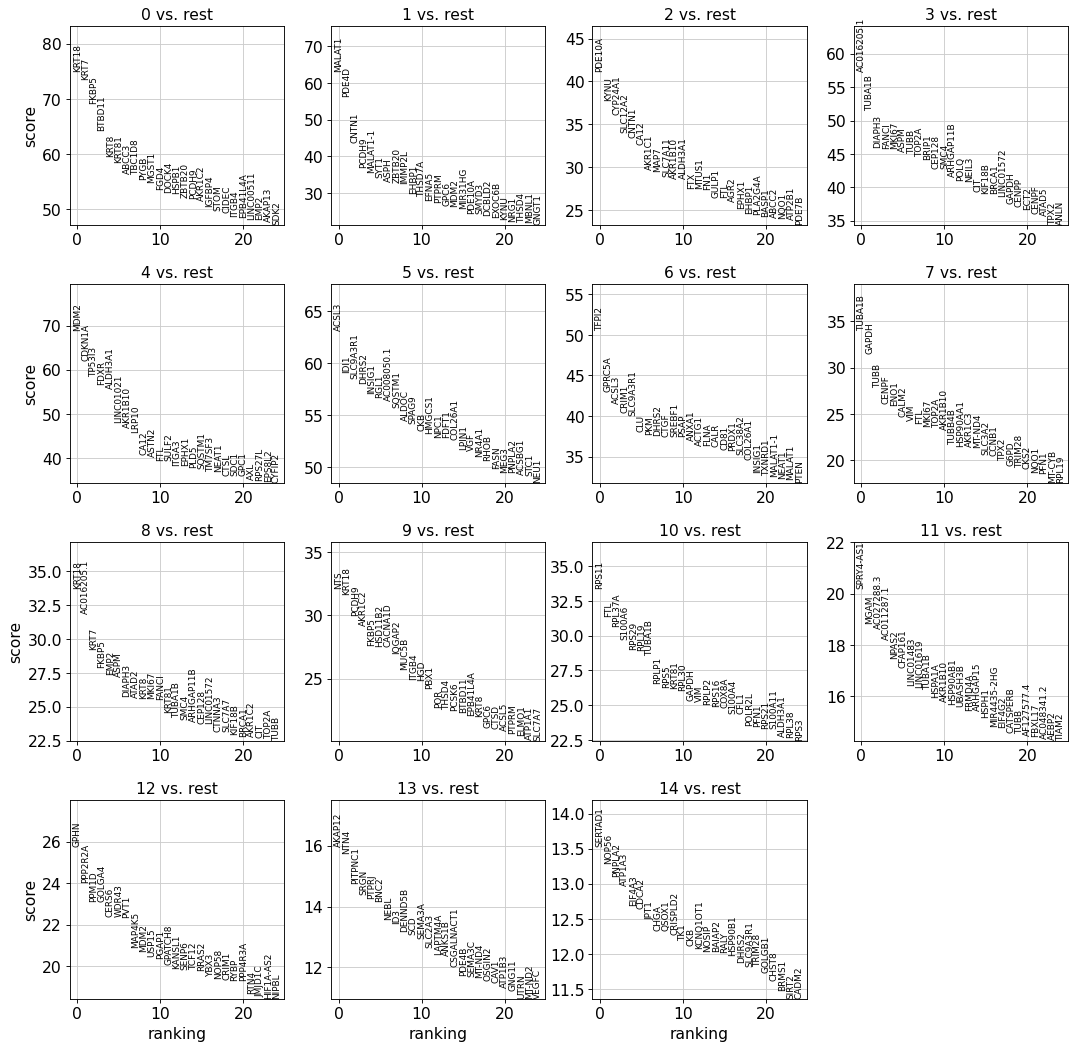

In [51]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [52]:
adata.write(results_file)

## Annotation of groups

In [62]:
top10_genes_by_cluster = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

In [75]:
marker_genes = set(top10_genes_by_cluster.iloc[[0, 1], :].values.ravel())
marker_genes = list(marker_genes)

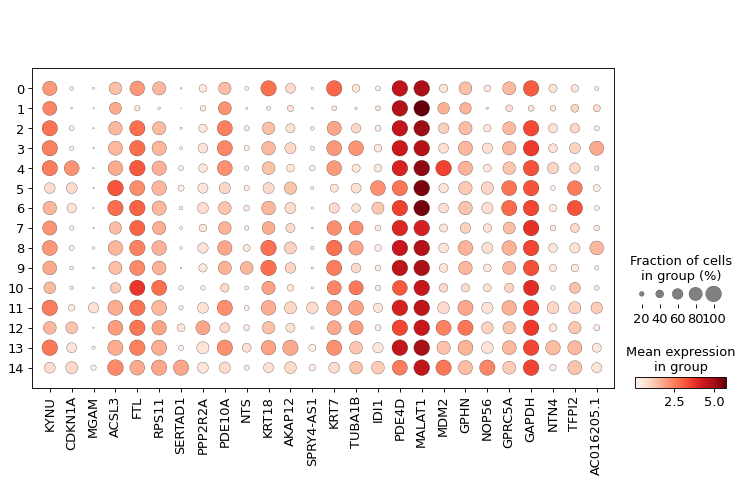

In [76]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

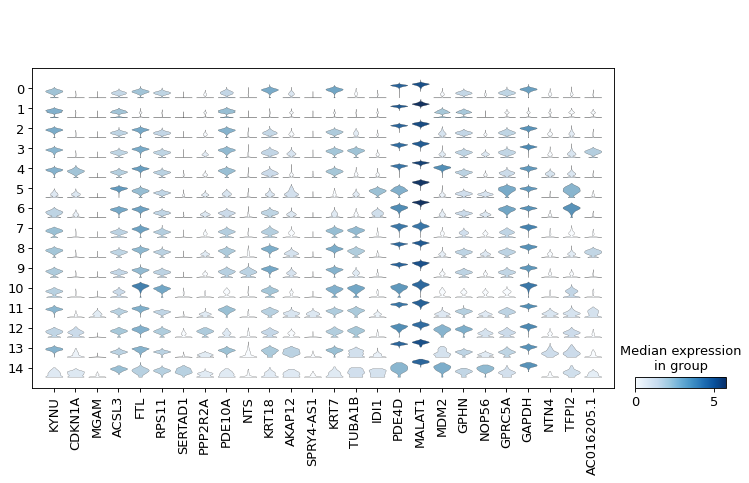

In [77]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90)

In [78]:
adata

AnnData object with n_obs × n_vars = 24135 × 4194
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'